### First read data from the disk

In [32]:
import pandas as pd
import numpy as np
import cv2

directory = 'training_data1'
df = pd.read_csv('./'+directory+'/driving_log.csv')
df.columns = ['center','left','right','steering','throttle','brake','speed']

nb_training_data = df.center.shape[0]
X_training =  np.zeros([nb_training_data, 160,320,3 ], dtype=np.uint8)

index = 0
for line in range(nb_training_data):
    source_path = df.center[line]
    filename = source_path.split('/')[-1]
    current_path = './'+directory+'/IMG/'+filename
    image = cv2.imread(current_path, cv2.IMREAD_COLOR)
    X_training[index] = image
    index+=1

# read label from df
lable_y = df.as_matrix(columns=['steering'])
y_train = lable_y[:,0]

### Visualize training data

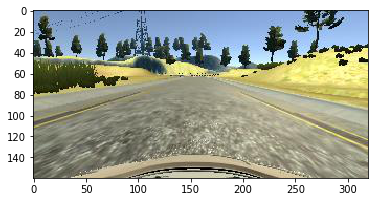

In [33]:
import matplotlib.pyplot as plt
import random
%matplotlib inline
random_image = random.randint(0 , nb_training_data)   
plt.imshow( cv2.cvtColor(X_training[random_image], cv2.COLOR_BGR2RGB) )


### Data augmentation

In [36]:
X_training_flip = np.zeros([nb_training_data, 160 , 320 , 3 ], dtype=np.uint8)

for i in range(X_training.shape[0]):
    X_training_flip[i] =  np.fliplr(X_training[i])
y_train_flip = -y_train


In [45]:
# stack training data
X_train_aug =  np.vstack( (X_training,X_training_flip) 
y_train_aug =  np.concatenate(y_train, y_train_flip)

AttributeError: 'numpy.ndarray' object has no attribute 'vstack'

,center,left,right,steering,throttle,brake,speed
0,/home/cd/udacity_workspace/CarND-Behavioral-Cl...,/home/cd/udacity_workspace/CarND-Behavioral-Cl...,/home/cd/udacity_workspace/CarND-Behavioral-Cl...,0.000000,0.000000,0.0,0.000005
1,/home/cd/udacity_workspace/CarND-Behavioral-Cl...,/home/cd/udacity_workspace/CarND-Behavioral-Cl...,/home/cd/udacity_workspace/CarND-Behavioral-Cl...,0.000000,0.000000,0.0,0.000006
2,/home/cd/udacity_workspace/CarND-Behavioral-Cl...,/home/cd/udacity_workspace/CarND-Behavioral-Cl...,/home/cd/udacity_workspace/CarND-Behavioral-Cl...,0.000000,0.000000,0.0,0.000006
3,/home/cd/udacity_workspace/CarND-Behavioral-Cl...,/home/cd/udacity_workspace/CarND-Behavioral-Cl...,/home/cd/udacity_workspace/CarND-Behavioral-Cl...,0.000000,0.000000,0.0,0.000006
4,/home/cd/udacity_workspace/CarND-Behavioral-Cl...,/home/cd/udacity_workspace/CarND-Behavioral-Cl...,/home/cd/udacity_workspace/CarND-Behavioral-Cl...,0.000000,0.000000,0.0,0.000006
5,/home/cd/udacity_workspace/CarND-Behavioral-Cl...,/home/cd/udacity_workspace/CarND-Behavioral-Cl...,/home/cd/udacity_workspace/CarND-Behavioral-Cl...,0.000000,0.000000,0.0,0.000006
6,/home/cd/udacity_workspace/CarND-Behavioral-Cl...,/home/cd/udacity_workspace/CarND-Behavioral-Cl...,/home/cd/udacity_workspace/CarND-Behavioral-Cl...,0.000000,0.000000,0.0,0.000006
7,/home/cd/udacity_workspace/CarND-Behavioral-Cl...,/home/cd/udacity_workspace/CarND-Behavioral-Cl...,/home/cd/udacity_workspace/CarND-Behavioral-Cl...,0.000000,0.000000,0.0,0.000006
8,/home/cd/udacity_workspace/CarND-Behavioral-Cl...,/home/cd/udacity_workspace/CarND-Behavioral-Cl...,/home/cd/udacity_workspace/CarND-Behavioral-Cl...,0.000000,0.000000,0.0,0.000007
9,/home/cd/udacity_workspace/CarND-Behavioral-Cl...,/home/cd/udacity_workspace/CarND-Behavioral-Cl...,/home/cd/udacity_workspace/CarND-Behavioral-Cl...,0.000000,0.000000,0.0,0.000005


In [17]:
from keras.models import Sequential
from keras.layers import Conv2D, Flatten, Dense , Lambda, MaxPooling2D, Dropout,Cropping2D

i_shape = (160, 320,3)

model = Sequential()
model.add(Lambda(lambda x: x / 255.0 - 0.5, input_shape=i_shape ))
model.add(Cropping2D(cropping=((50,20), (0,0)), input_shape=(160,320,3)))

# conv_net
model.add(Conv2D( 6, 5, 5, activation='relu', input_shape = i_shape))
model.add(Conv2D( 6, 5, 5,  activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
########################################################################
# conv_net
model.add(Conv2D(16, 3, 3, activation='relu'))
model.add(Conv2D(16, 3, 3, activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
#########################################################################
model.add(Flatten())
model.add(Dense(400, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(84, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='relu'))
model.compile(loss='mse',optimizer='adam')
model.fit(X_training, y_train, validation_split = 0.2, shuffle=True)
model.save('first_model.h5')




Train on 2418 samples, validate on 605 samples
Epoch 1/10
2418/2418 [==============================] - 307s - loss: 0.0226 - val_loss: 0.0587
Epoch 2/10
1088/2418 [============>.................] - ETA: 153s - loss: 0.0187

KeyboardInterrupt: 